# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [27]:
import os
import cv2
from PIL import Image
import optuna
import atom
import atom.data_cleaning as dc
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
path = '../data/images'
pixels_per_side = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [52]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
classes = {0: 'Danaus plexippus',
              1: 'Heliconius charitonius',
              2: 'Heliconius erato',
              3: 'Junonia coenia',
              4: 'Lycaena phlaeas',
              5: 'Nymphalis antiopa',
              6: 'Papilio cresphontes',
              7: 'Pieris rapae',
              8: 'Vanessa atalanta',
              9: 'Vanessa cardui'}

In [31]:
print([classes[labels[i]] for i in range(10)]) 

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


In [32]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

In [53]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

In [34]:
print(mean, std)

[0.4616279900074005, 0.4468429684638977, 0.3207762539386749] [0.2861473262310028, 0.2681962549686432, 0.27681371569633484]


Display some samples

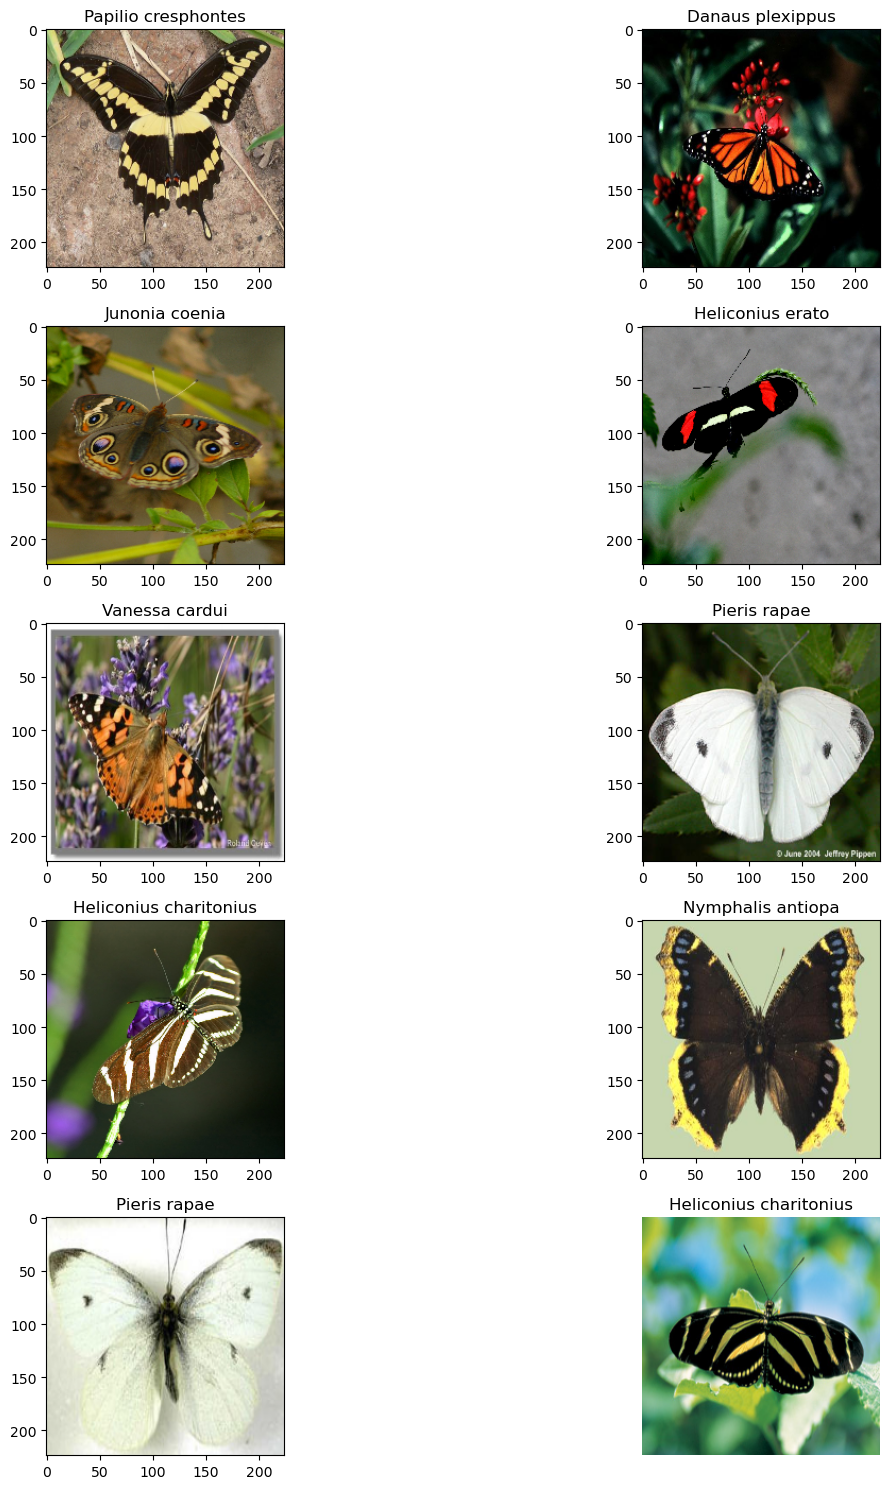

In [35]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')        
plt.tight_layout()

Display dataset distribution

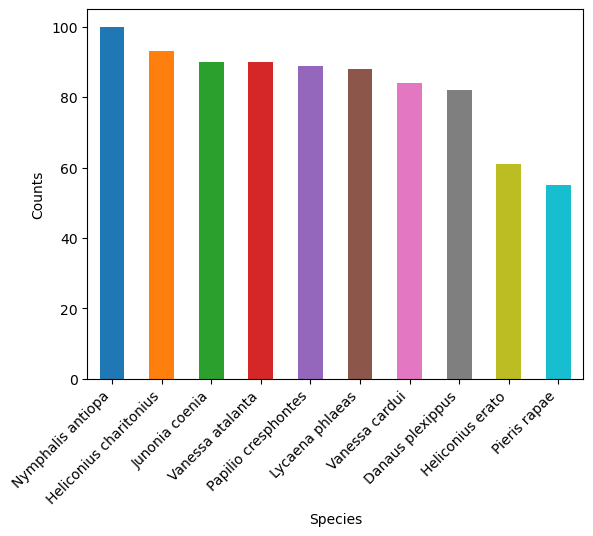

In [36]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(classes)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

### Data cleaning

Use this to check dataset shape

In [59]:
print(data.shape, labels.shape)
print(data)
print(labels)

(820, 3, 224, 224) (820,)
[[[[-0.8457886  -0.7635603  -0.6676272  ... -0.10573377  0.12724642
     0.25058898]
   [-0.81837916 -0.7909697  -0.70874137 ... -0.07832434  0.00390397
     0.20947485]
   [-0.7635603  -0.777265   -0.7498556  ... -0.03721019 -0.10573377
     0.18206541]
   ...
   [-0.00980075 -0.00980075 -0.06461962 ... -0.3524187  -0.4483517
    -0.5579895 ]
   [ 0.07242756  0.00390397 -0.0509149  ... -0.42094228 -0.5168753
    -0.69503665]
   [ 0.01760869 -0.02350547 -0.07832434 ... -0.48946586 -0.61280835
    -0.777265  ]]

  [[ 0.27862316  0.30786717  0.3663552  ...  0.4540873   0.5125753
     0.9951017 ]
   [ 0.29324517  0.29324517  0.3371112  ...  0.4687093   0.4540873
     0.81963754]
   [ 0.3224892   0.30786717  0.30786717 ...  0.5125753   0.42484325
     0.6295514 ]
   ...
   [ 1.0389677   1.0828338   1.0974557  ...  0.29324517  0.2055131
     0.14702496]
   [ 1.1559438   1.1413218   1.1413218  ...  0.24937914  0.2055131
     0.0739149 ]
   [ 1.1413218   1.1705658   

Scaling the Feature Set: standardize your dataset to ensure all features are on a similar scale.

In [54]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
data = []
for img, _ in dataloader:
    data.append(img.numpy())
data = np.concatenate(data, axis=0)

Flatten data for ingestion to Atom objects

In [56]:
data = data.reshape(len(data), -1)

Handling Outliers: detect and manage outliers in your dataset.

In [57]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                          device='cpu',
                          engine='sklearn',
                          verbose=2,
                          iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                          lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                          )
                .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 12 outliers.
 --> The IsolationForest detected 276 outliers.
 --> Dropping 12 outliers.


In [58]:
data = data.values.reshape(-1, 3, pixels_per_side, pixels_per_side)
labels = labels.values

## Training pipeline

Split into training data and test data

In [60]:
dataset = MyDataset(data, labels)
trainset, testset = random_split(dataset, [0.85, 0.15])
testloader = DataLoader(testset, batch_size=64, shuffle=False)

CNN definition

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120 * 49 * 49, 64) # ((224 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 220, 220]          456
├─MaxPool2d: 1-2                         [1, 6, 110, 110]          --
├─Conv2d: 1-3                            [1, 16, 106, 106]         2,416
├─MaxPool2d: 1-4                         [1, 16, 53, 53]           --
├─Conv2d: 1-5                            [1, 120, 49, 49]          48,120
├─Flatten: 1-6                           [1, 288120]               --
├─Linear: 1-7                            [1, 64]                   18,439,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 18,491,386
Trainable params: 18,491,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 183.19
Input size (MB): 0.60
Forward/backward pass size (MB): 6.07
Params size (MB): 73.97
Estimated Total Size (MB): 80.63

Train and validate methods

In [62]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss = acc = count = 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = net(features)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(logits, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

def predict(net, valloader, loss_fn):
    net.eval()
    count = acc = total_loss = 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            logits = net(features)
            total_loss += loss_fn(logits, labels)
            pred = torch.max(logits, 1)[1]
            acc += (pred == labels).sum()
    return total_loss.item() / count, acc.item() / count

Objective method for k fold cross validation

In [66]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    epochs = trial.suggest_int('epochs', 5, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    val_accs = []
    for train_index, val_index in skf.split(trainset.dataset.data, trainset.dataset.labels):
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, train_acc = fit(net, trainloader, optimizer, criterion)
            val_loss, val_acc = predict(net, valloader, criterion)
            print(f"Epoch {epoch + 1:2}, Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        val_accs.append(val_acc)
    return np.mean(val_accs)

In [67]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial), n_trials=100)

/tmp/ipykernel_27294/3524409070.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[W 2024-07-22 16:04:44,008] Trial 0 failed with parameters: {'lr': 0.0018464203552763687, 'batch_size': 256, 'epochs': 28, 'optimizer': 'SGD'} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/home/vito/miniconda3/envs/pyatom/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_27294/2603502317.py", line 2, in <lambda>
    study.optimize(lambda trial: objective(trial), n_trials=100)
                                 ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_27294/3524409070.py", line 20, in objective
    train_loss, train_acc = fit(net, trainloader, optimizer, criteri

IndexError: list index out of range